## Technical Report Notebook 3 - Testing

### Hail Modelling and Algorithm Investigation

In [3]:
# Import modelling libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.decomposition import PCA

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# Reading in data 

hail_tweet_text = pd.read_csv("./hail_tweet_text.csv")
hail_tweet_text.drop('Unnamed: 0',axis=1,inplace=True)

### Create Hail Class

In [5]:
# Create hail class for classification analysis

hail_tweet_text['hail_class'] = 0

hail_tweet_text.ix[hail_tweet_text['hail'] >= 1, 'hail_class'] = 1
hail_tweet_text.ix[hail_tweet_text['hailstorm'] >= 1, 'hail_class'] = 1

hail_tweet_text_bris = hail_tweet_text[hail_tweet_text['Cat_ID'] == 144]
hail_tweet_text_syd = hail_tweet_text[hail_tweet_text['Cat_ID'] == 154]

In [6]:
# Create subsets of data for train/testing

In [7]:
htt_total = hail_tweet_text.ix[:,26:]
print (htt_total.shape)
htt_bris = hail_tweet_text_bris.ix[:,26:]
print (htt_bris.shape)
htt_syd = hail_tweet_text_syd.ix[:,26:]
print (htt_syd.shape)

y_total = htt_total.hail_class
y_bris = htt_bris.hail_class
y_syd = htt_syd.hail_class

(127989, 1002)
(46529, 1002)
(81460, 1002)


In [8]:
htt_total.drop(htt_total[['sydney','sydneystorm','brisbane','brisbanestorm','hail','hailstorm','hail_class']], axis=1, inplace=True)
htt_bris.drop(htt_bris[['sydney','sydneystorm','brisbane','brisbanestorm','hail','hailstorm','hail_class']], axis=1, inplace=True)
htt_syd.drop(htt_syd[['sydney','sydneystorm','brisbane','brisbanestorm','hail','hailstorm','hail_class']], axis=1, inplace=True)

In [9]:
ss = StandardScaler()

Xs_htt_total = ss.fit_transform(htt_total)
Xs_htt_bris = ss.fit_transform(htt_bris)
Xs_htt_syd = ss.fit_transform(htt_syd)

## Principle Component Analysis

In [10]:
# PCA On Full Dataset Set

pca = PCA()
pca.fit(Xs_htt_total)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [11]:
pca.explained_variance_ratio_.max()

0.011864892485503162

In [12]:
htt_pcs = pca.transform(Xs_htt_total)
htt_pcs = pd.DataFrame(htt_pcs, 
                       columns=['PC'+str(i+1) for i in range(len(htt_total.columns))],
                       index=htt_total.index)

In [13]:
htt_pcs.index.values

array([     0,      1,      2, ..., 127986, 127987, 127988])

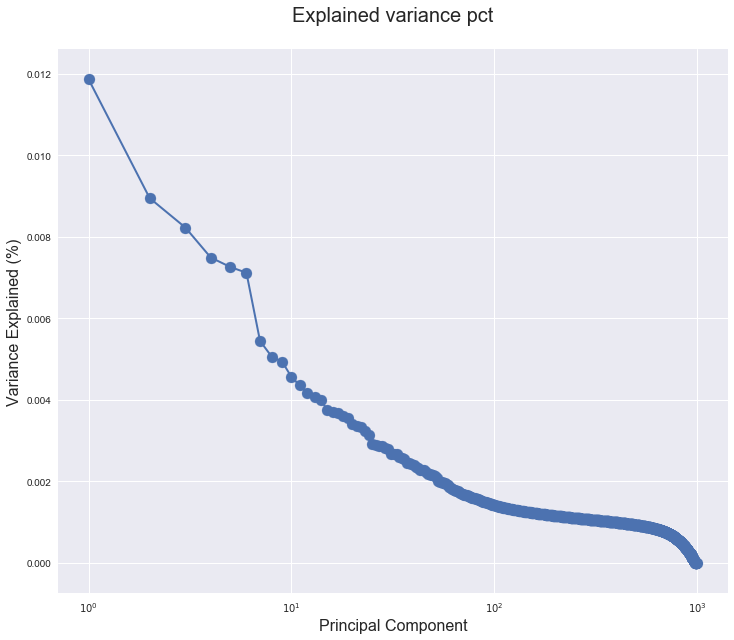

In [14]:
exp_var = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(12,10))
ax.plot(range(1, len(exp_var)+1), exp_var, lw=2)
ax.scatter(range(1, len(exp_var)+1), exp_var, s=120)
ax.set_title('Explained variance pct\n', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Variance Explained (%)', fontsize=16)
plt.xscale('log')
plt.show()

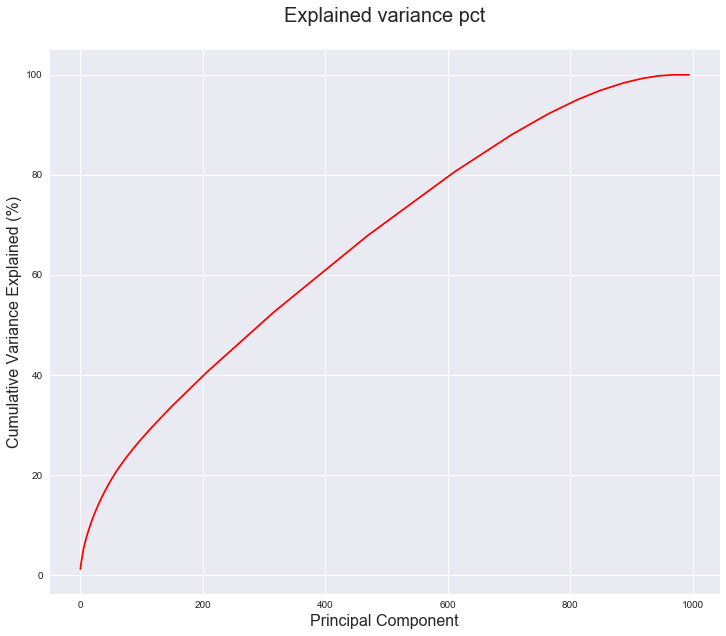

In [15]:
fig, ax = plt.subplots(figsize=(12,10))
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
ax.set_title('Explained variance pct\n', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Cumulative Variance Explained (%)', fontsize=16)
plt.plot(var1,color='red')

In [16]:
components = pd.DataFrame(pca.components_,
                 columns=['PC'+str(i+1) for i in range(len(htt_total.columns))],
                 index=htt_total.columns)
print (components['PC1'].nlargest(10))
print ("-----------")
print (components['PC2'].nlargest(10))
print ("-----------")
print (components['PC3'].nlargest(10))
print ("-----------")
print (components['PC4'].nlargest(10))
print ("-----------")
print (components['PC5'].nlargest(10))
print ("-----------")
print (components['PC6'].nlargest(10))

wolf        0.806483
actually    0.351023
warnings    0.194130
bc          0.081956
warning     0.060724
tracking    0.033305
steal       0.030616
spring      0.023535
big         0.023450
starts      0.022062
Name: PC1, dtype: float64
-----------
black       0.184392
birthday    0.104094
soar        0.102554
solar       0.097632
street      0.090399
strike      0.085942
online      0.080470
near        0.075847
people      0.074541
poor        0.073281
Name: PC2, dtype: float64
-----------
perxitaa    0.109993
ninja       0.102606
pacers      0.102115
park        0.100281
rainbow     0.098990
damaged     0.095521
pictures    0.095394
die         0.093282
mother      0.092254
nov         0.091262
Name: PC3, dtype: float64
-----------
beta          0.271425
struggling    0.139754
borno         0.136827
straight      0.136193
star          0.125487
book          0.118656
southern      0.115534
snarls        0.114655
brewing       0.105982
somerset      0.103702
Name: PC4, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


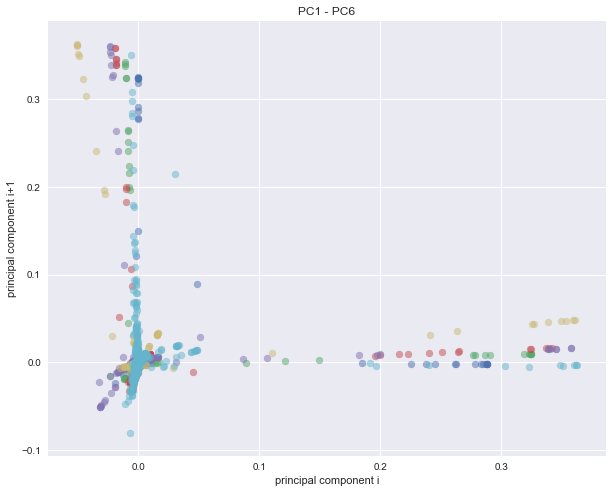

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pca.components_[0], pca.components_[1], alpha=0.5)
ax.scatter(pca.components_[1], pca.components_[2], alpha=0.5)
ax.scatter(pca.components_[2], pca.components_[3], alpha=0.5)
ax.scatter(pca.components_[3], pca.components_[4], alpha=0.5)
ax.scatter(pca.components_[4], pca.components_[5], alpha=0.5)
ax.scatter(pca.components_[5], pca.components_[6], alpha=0.5)
ax.set_title('PC1 - PC6')
ax.set_xlabel('principal component i')
ax.set_ylabel('principal component i+1')
ax.legend()
plt.show()

PCA Insights:
    
............


## Hail Modelling

Investigate classification algorithm appropriate for text classification exercises:
    - Naive Bayes
    - Stochastic Gradient Descent
    - Decision Tree
    - Random Forest (Ensemble)

### Naive Bayes Classification

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

tf_transformer = TfidfTransformer(use_idf=False).fit(htt_total)
X_total_tf = tf_transformer.transform(htt_total)

X_train, X_test, y_train, y_test = train_test_split(X_total_tf, y_total, test_size=0.8)

mnb_tot = MultinomialNB()
mnb_tot.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [22]:
# Create function to print modelling results:

def model_results(X,y,model):
    
    scores = cross_val_score(model, X, y, cv=5)

    print (str(model))
    print ("--------")
    print ("scores:")
    print (scores)
    print ("--------")
    print ("avg score:")
    print (sum(scores)/len(scores))
    print ("--------")
    
    yhat = model.predict(X)

    # Sum all the true/false positives/negatives combinations

    tp = np.sum((y == 1) & (yhat == 1))
    fp = np.sum((y == 0) & (yhat == 1))
    tn = np.sum((y == 0) & (yhat == 0))
    fn = np.sum((y == 1) & (yhat == 0))

    # convert the predicted and actual values to a confusion array

    confusion_array = np.array(confusion_matrix(y, yhat, labels=[1,0]))

    confusion = pd.DataFrame(confusion_array, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
    
    
    print ("confusion matrix")
    print (confusion)
    print ("--------")
    print ("accuracy:", accuracy_score(y, yhat)) # accuracy = (tp + tn) / total_population)
    print ("false positive rate", float(fp) / (tn + fp))
    print ("specificity", float(tn) / (tn + fp))
    print ("--------")
    print (classification_report(y, yhat))
    # Precision = True Positives / (True Positives + False Positives)

In [23]:
model_results(X_test,y_test,mnb_tot)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
--------
scores:
[ 0.96801602  0.96884614  0.96816251  0.96943061  0.96884309]
--------
avg score:
0.968659672023
--------
confusion matrix
         predicted_hail  predicted_no_hail
hail                599               3314
no hail              41              98438
--------
accuracy: 0.967233768263
false positive rate 0.000416332416048
specificity 0.999583667584
--------
             precision    recall  f1-score   support

          0       0.97      1.00      0.98     98479
          1       0.94      0.15      0.26      3913

avg / total       0.97      0.97      0.96    102392



In [21]:
mb_coefficients = pd.DataFrame(data=mnb_tot.feature_log_prob_,columns=htt_total.columns)
mb_coefficients = mb_coefficients.T
mb_coefficients.sort_values(1, ascending=False, inplace=True)
mb_coefficients.head(20)

,0,1
sentiment,-1.544925,-1.919857
storm,-2.477188,-2.439189
massive,-6.445174,-4.630863
severe,-6.401811,-4.699882
damage,-3.292459,-4.711970
causes,-7.194140,-4.760556
chaos,-8.464463,-4.761168
slammed,-10.290174,-4.761485
worst,-7.283507,-4.828642
rain,-5.346500,-4.847939


### Stochastic Gradient Descent Classification

In [26]:
parameters = {
    'alpha': (0.0001, 0.000001),
    'penalty': ('l2', 'elasticnet'),
    'n_iter': (10, 50, 80),
}

sgd = SGDClassifier(loss='modified_huber')

sgd_gs = GridSearchCV(sgd, parameters, cv=5, verbose=1, refit=True)

sgd_gs.fit(X_train, y_train)

print (sgd_gs.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'alpha': 0.0001, 'n_iter': 10, 'penalty': 'l2'}


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    8.1s finished


In [27]:
best_sgd = sgd_gs.best_estimator_

coef_df_overall = pd.DataFrame({
        'coefficient':np.abs(best_sgd.coef_[0]),
        'feature':htt_total.columns})

coef_df_overall.sort('coefficient',ascending=False).head(10)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,coefficient,feature
757,2.791777,sized
761,2.412927,slammed
141,2.391309,chaos
441,2.081813,large
756,1.993786,size
829,1.408600,sydneyweather
133,1.388735,cdt
582,1.358242,nsw
2,1.313002,abcnews
869,1.244586,thunderstorms


In [28]:
model_results(X_test,y_test,sgd_gs)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   41.5s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   41.3s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   45.0s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   39.0s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   48.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': (0.0001, 1e-06), 'penalty': ('l2', 'elasticnet'), 'n_iter': (10, 50, 80)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)
--------
scores:
[ 0.96933444  0.97021339  0.96918795  0.97021193  0.96986863]
--------
avg score:
0.969763269195
--------
confusion matrix
         predicted_hail  predicted_no_hail
hail               1170               2743
no hail             301              98178
--------
accuracy: 0.970271114931
false positive rate 0.00305648920074
specificity 0.996943510799
--------
             pr

### Decision Tree Classification

In [29]:
# Decision Tree gridsearch to get the optimal decision tree model

dtc_params = {
    'max_depth':[None,1,2,3,4,5,6,7,8,9,10],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]}

from sklearn.model_selection import GridSearchCV

dtc = DecisionTreeClassifier()
dtc_gs = GridSearchCV(dtc, dtc_params, cv=5, verbose=1, refit=True)

dtc_gs.fit(X_train, y_train)

dtc_best = dtc_gs.best_estimator_

print (dtc_gs.best_params_)

Fitting 5 folds for each of 847 candidates, totalling 4235 fits
{'max_depth': 10, 'max_features': None, 'min_samples_split': 3}


[Parallel(n_jobs=1)]: Done 4235 out of 4235 | elapsed:  3.3min finished


In [30]:
dtr_ds = DecisionTreeClassifier(max_features=None,min_samples_split=5,max_depth=10)

dtr_ds.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [31]:
# Extract the top features from the decision tree classifier.

top_features_DS = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':dtr_ds.feature_importances_})

top_features_DS.sort_values('importance', ascending=False, inplace=True)
top_features_DS.head(10)

,feature,importance
761,slammed,0.182331
141,chaos,0.158512
757,sized,0.118962
441,large,0.072241
756,size,0.070478
994,sentiment,0.068787
131,causes,0.049705
2,abcnews,0.033198
41,australia,0.032739
829,sydneyweather,0.032684


In [32]:
model_results(X_test,y_test,dtr_ds)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
--------
scores:
[ 0.9694321   0.97060403  0.96913912  0.9708956   0.97006397]
--------
avg score:
0.970026964437
--------
confusion matrix
         predicted_hail  predicted_no_hail
hail                941               2972
no hail             240              98239
--------
accuracy: 0.968630361747
false positive rate 0.00243706780126
specificity 0.997562932199
--------
             precision    recall  f1-score   support

          0       0.97      1.00      0.98     98479
          1       0.80      0.24      0.37      3913

avg / total       0.96      0.97      0.96    102392



### Random Forest Classification

In [24]:
from sklearn.ensemble import RandomForestClassifier

# build a classifier
rfc = RandomForestClassifier(n_estimators=20)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
rfc_gs = GridSearchCV(rfc, param_grid=param_grid)

rfc_gs.fit(X_train, y_train)

rfc_gs.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [25]:
model_results(X_test,y_test,rfc_gs)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
--------
scores:
[ 0.97236193  0.97304556  0.97314322  0.9741674   0.97226156]
--------
avg score:
0.972995934279
--------
confusion matrix
         predicted_hail  predicted_no_hail
hail               1045        

#### Plot all ROC Curves for models

In [ ]:
# Plot the ROC curve:

from sklearn.metrics import roc_curve, auc

yhat_mnb = mnb_tot.predict_proba(X_test)
yhat_sgd = sgd_gs.predict_proba(X_test)
yhat_dtc = dtr_ds.predict_proba(X_test)
yhat_rfc = rfc_gs.predict_proba(X_test)

# naive bayes roc/auc calculation
fpr_mnb, tpr_mnb, _ = roc_curve(y_test, yhat_mnb[:,1])
roc_auc_mnb = auc(fpr_mnb, tpr_mnb)

# sgd roc/auc calculation
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, yhat_sgd[:,1])
roc_auc_sgd = auc(fpr_dtc, tpr_dtc)

# decision tree roc/auc calculation
fpr_dtc, tpr_dtc, _ = roc_curve(y_test, yhat_dtc[:,1])
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)

# random forest roc/auc calculation
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, yhat_rfc[:,1])
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

plt.figure(figsize=[12,12])

plt.plot(fpr_mnb, tpr_mnb, label='mnb' % roc_auc_mnb, linewidth=4)
plt.plot(fpr_sgd, tpr_sgd, label='sgd' % roc_auc_sgd, linewidth=4)
plt.plot(fpr_dtc, tpr_dtc, label='dtc' % roc_auc_dtc, linewidth=4)
plt.plot(fpr_rfc, tpr_rfc, label='rfc' % roc_auc_rfc, linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic: hail class', fontsize=15)
plt.legend(loc="lower right")
plt.show()

###  Random Forest Classification 

Determining optimal hyperparameters using full dataset

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# build a classifier
rfc = RandomForestClassifier(n_estimators=20)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
rfc_gs = GridSearchCV(rfc, param_grid=param_grid)

rfc_gs.fit(X_total_tf, y_total)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [39]:
rfc_gs.best_score_

0.96816132636398444

In [38]:
# Create predicted y values for decision tree analysis 

yhat_total_rfc = rfc_gs.predict(X_total_tf)
yhat_total_rfc_pp = rfc_gs.predict_proba(X_total_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_total == 1) & (yhat_total_rfc == 1))
fp = np.sum((y_total == 0) & (yhat_total_rfc == 1))
tn = np.sum((y_total == 0) & (yhat_total_rfc == 0))
fn = np.sum((y_total == 1) & (yhat_total_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc = np.array(confusion_matrix(y_total, yhat_total_rfc, labels=[1,0]))

confusion_rfc = pd.DataFrame(confusion_array_rfc, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc

,predicted_hail,predicted_no_hail
hail,3202,1703
no hail,81,123003


In [ ]:
rfc_total_bris = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Extract the top features from the decision tree classifier.
rfc_total_bris.fit(X_bris_tf, y_bris)

top_features_rfc_bris = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':rfc_total_bris.feature_importances_})

top_features_rfc_bris.sort_values('importance', ascending=False, inplace=True)
print (top_features_rfc_bris.head(20))

# Create predicted y values for decision tree analysis 

yhat_syd_rfc = rfc_total.predict(X_syd_tf)
yhat_syd_rfc_pp = rfc_total.predict_proba(X_syd_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_syd == 1) & (yhat_syd_rfc == 1))
fp = np.sum((y_syd == 0) & (yhat_syd_rfc == 1))
tn = np.sum((y_syd == 0) & (yhat_syd_rfc == 0))
fn = np.sum((y_syd == 1) & (yhat_syd_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_syd = np.array(confusion_matrix(y_syd, yhat_syd_rfc, labels=[1,0]))

confusion_rfc_syd = pd.DataFrame(confusion_array_rfc_syd, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_syd

In [ ]:
rfc_total_syd = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Extract the top features from the decision tree classifier.
rfc_total_syd.fit(X_syd_tf, y_syd)

top_features_rfc_syd = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':rfc_total_syd.feature_importances_})

top_features_rfc_syd.sort_values('importance', ascending=False, inplace=True)
print (top_features_rfc_syd.head(20))

# Create predicted y values for decision tree analysis 

yhat_bris_rfc = rfc_total.predict(X_bris_tf)
yhat_bris_rfc_pp = rfc_total.predict_proba(X_bris_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_bris == 1) & (yhat_bris_rfc == 1))
fp = np.sum((y_bris == 0) & (yhat_bris_rfc == 1))
tn = np.sum((y_bris == 0) & (yhat_bris_rfc == 0))
fn = np.sum((y_bris == 1) & (yhat_bris_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_bris = np.array(confusion_matrix(y_bris, yhat_bris_rfc, labels=[1,0]))

confusion_rfc_bris = pd.DataFrame(confusion_array_rfc_bris, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_bris

### Brisbane Train / Sydney Test - Random Forest Classification

In [ ]:
tf_transformer_bris = TfidfTransformer(use_idf=False).fit(htt_bris)
tf_transformer_syd = TfidfTransformer(use_idf=False).fit(htt_syd)
X_bris_tf = tf_transformer.transform(htt_bris)
X_syd_tf = tf_transformer.transform(htt_syd)

In [ ]:
rfc_hp = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

rfc_hp.fit(X_bris_tf, y_bris)

rfc_hp_scores = cross_val_score(rfc_hp, X_syd_tf, y_syd, cv=5)

print (rfc_hp_scores)
print (sum(rfc_hp_scores)/len(rfc_hp_scores))

In [ ]:
# Extract the top features from the decision tree classifier.

top_features_rfc = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':rfc_hp.feature_importances_})

top_features_rfc.sort_values('importance', ascending=False, inplace=True)
top_features_rfc.head(20)

In [ ]:
# Create predicted y values for decision tree analysis 

yhat_syd_rfc = rfc_hp.predict(X_syd_tf)
yhat_syd_rfc_pp = rfc_hp.predict_proba(X_syd_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_syd == 1) & (yhat_syd_rfc == 1))
fp = np.sum((y_syd == 0) & (yhat_syd_rfc == 1))
tn = np.sum((y_syd == 0) & (yhat_syd_rfc == 0))
fn = np.sum((y_syd == 1) & (yhat_syd_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_syd = np.array(confusion_matrix(y_syd, yhat_syd_rfc, labels=[1,0]))

confusion_rfc_syd = pd.DataFrame(confusion_array_rfc_syd, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_syd

In [ ]:
# Create predicted y values for decision tree analysis 

yhat_bris_rfc = rfc_hp.predict(X_bris_tf)
yhat_bris_rfc_pp = rfc_hp.predict_proba(X_bris_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_bris == 1) & (yhat_bris_rfc == 1))
fp = np.sum((y_bris == 0) & (yhat_bris_rfc == 1))
tn = np.sum((y_bris == 0) & (yhat_bris_rfc == 0))
fn = np.sum((y_bris == 1) & (yhat_bris_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_bris = np.array(confusion_matrix(y_bris, yhat_bris_rfc, labels=[1,0]))

confusion_rfc_bris = pd.DataFrame(confusion_array_rfc_bris, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_bris

### Sydney Train / Brisbane Test - Random Forest Classification

In [ ]:
rfc_hp_syd = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

rfc_hp_syd.fit(X_syd_tf, y_syd)

rfc_hp_scores = cross_val_score(rfc_hp_syd, X_syd_tf, y_syd, cv=5)

print (rfc_hp_scores)
print (sum(rfc_hp_scores)/len(rfc_hp_scores))

In [ ]:
# Extract the top features from the decision tree classifier.

top_features_rfc_syd = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':rfc_hp_syd.feature_importances_})

top_features_rfc.sort_values('importance', ascending=False, inplace=True)
top_features_rfc.head(20)

In [ ]:
# Create predicted y values for decision tree analysis 

yhat_bris_rfc = rfc_hp_syd.predict(X_bris_tf)
yhat_bris_rfc_pp = rfc_hp_syd.predict_proba(X_bris_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_bris == 1) & (yhat_bris_rfc == 1))
fp = np.sum((y_bris == 0) & (yhat_bris_rfc == 1))
tn = np.sum((y_bris == 0) & (yhat_bris_rfc == 0))
fn = np.sum((y_bris == 1) & (yhat_bris_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_bris = np.array(confusion_matrix(y_bris, yhat_bris_rfc, labels=[1,0]))

confusion_rfc_bris = pd.DataFrame(confusion_array_rfc_bris, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_bris

In [ ]:
# Create predicted y values for decision tree analysis 

yhat_syd_rfc = rfc_hp.predict(X_syd_tf)
yhat_syd_rfc_pp = rfc_hp.predict_proba(X_syd_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_syd == 1) & (yhat_syd_rfc == 1))
fp = np.sum((y_syd == 0) & (yhat_syd_rfc == 1))
tn = np.sum((y_syd == 0) & (yhat_syd_rfc == 0))
fn = np.sum((y_syd == 1) & (yhat_syd_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_syd = np.array(confusion_matrix(y_syd, yhat_syd_rfc, labels=[1,0]))

confusion_rfc_syd = pd.DataFrame(confusion_array_rfc_syd, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_syd

In [ ]:
rfc_total = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Extract the top features from the decision tree classifier.
rfc_total.fit(X_total_tf, y_total)

top_features_rfc = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':rfc_total.feature_importances_})

top_features_rfc.sort_values('importance', ascending=False, inplace=True)
print (top_features_rfc.head(20))

# Create predicted y values for decision tree analysis 

yhat_total_rfc = rfc_total.predict(X_total_tf)
yhat_total_rfc_pp = rfc_total.predict_proba(X_total_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_total == 1) & (yhat_total_rfc == 1))
fp = np.sum((y_total == 0) & (yhat_total_rfc == 1))
tn = np.sum((y_total == 0) & (yhat_total_rfc == 0))
fn = np.sum((y_total == 1) & (yhat_total_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc = np.array(confusion_matrix(y_total, yhat_total_rfc, labels=[1,0]))

confusion_rfc = pd.DataFrame(confusion_array_rfc, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc